In [1]:
import os  # for making files and directories thru OS
import numpy as np
import matplotlib.pyplot as plt    
import cv2    #convolution for image processing 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer , Dense , Conv2D , MaxPooling2D , Input , Flatten
from tensorflow.keras.models import Model

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu , True)
    
# for handling gpu's performance as tensorflow could blow out your gpu if it is not controlled
# as of now I have 0 gpus
# this could also go for more than 1 gpus

In [4]:
len(gpus)

0

In [5]:
POS_PATH  = os.path.join('data' , 'positive')
NEG_PATH = os.path.join('data' , 'negative')
ANC_PATH = os.path.join('data' , 'anchor')
# this will join data directory to positive , neg , anc 
# like data\\positive

In [22]:
POS_PATH

'data\\positive'

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)
## this will make directories linked with or under data directory

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [8]:
!tar -xf lfw.tgz #tar -xf will unzip or uncompressed the lfw(labelled faces wild) file

tar: #tar: Not found in archive
tar: -xf: Not found in archive
tar: will: Not found in archive
tar: unzip: Not found in archive
tar: or: Not found in archive
tar: uncompressed: Not found in archive
tar: the: Not found in archive
tar: lfw(labelled: Not found in archive
tar: faces: Not found in archive
tar: wild): Not found in archive
tar: file: Not found in archive
tar: Error exit delayed from previous errors.


In [6]:
for directory in os.listdir('lfw'):      # to run through all the directories in lfw file
    for file in os.listdir(os.path.join('lfw' , directory)):  # it will run through all the files in those directory which is running in that for loop
        EX_PATH = os.path.join('lfw' , directory , file) # joining path and storing it as ex path --> lfw\\folder_name\\file_name(path)
        NEW_PATH = os.path.join(NEG_PATH , file) #joining path and storing it as new path --> negative\\file_name(path)
        os.replace(EX_PATH , NEW_PATH)
        

In [7]:
import uuid  #for naming images auto generated

In [8]:
cap = cv2.VideoCapture(0)       #will open video cam and in my case it is '0' device
while cap.isOpened():
    ret , frame  = cap.read() #this will return or it will unpack two things ret and frame
    frame = frame[170:170+250 , 220:220+250 :]   #resizing pics as 250x250
    cv2.imshow('My pictures' , frame)   #naming that frame/pics
    
    if cv2.waitKey(1) & 0XFF == ord('a'):  # while pressing 'a' it will auto named that pic and store it to anchor directory
        image_name = os.path.join(ANC_PATH , '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name , frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):   # while pressing 'a' it will auto named that pic and store it to anchor directory
        image_name = os.path.join(POS_PATH , '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(image_name , frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'): # while pressing 'q' it will close the cam and loop wil end
        break
        
cap.release() # 
cv2.destroyAllWindows() # it will destroy all the going operation

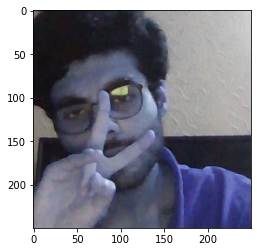

In [12]:
plt.imshow(frame) # matplotlib.pyplot.imshow will convert your frames to a image

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)

# here we are creating tensors datasets that takes 300 jpgs on anc/pos/neg paths 

In [10]:
testing_img = negative.as_numpy_iterator()
#this will iterate on these files

In [15]:
testing_img.next()

b'data\\negative\\John_Ashcroft_0039.jpg'

In [10]:
def preprocess(file_name):
    #for reading a file thru tf
    byte_img = tf.io.read_file(file_name)
    # loading that file
    img = tf.io.decode_image(byte_img , expand_animations=False )
    # resizing that image to 100x100x3 but the siamese paper says to resize it to 105x105x3 but we are setting things easy
    img = tf.image.resize(img , (100,100))
    #scaling the image from 0-1 so that our NN can easily understand the data (in form of np.array)
    img = img / 255.0
    
    return img

In [17]:
pic =  preprocess( 'data\\negative\\Richard_Haass_0001.jpg') 
# sending the argument to preproccess fnc to scale the values from 0 - 1

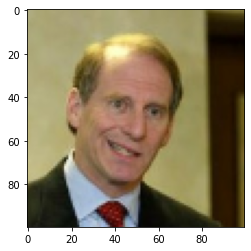

In [18]:
plt.imshow(pic)

In [11]:
negatives = tf.data.Dataset.zip((anchor ,  negative , tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
positives = tf.data.Dataset.zip((anchor , positive , tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# creating a dataset.zip so that tf can go thru both neg and pos  and the applying the negative pictures 0s and possitives as 1s


data = positives.concatenate(negatives)


# here concatenating the nges and pos (here the .zip will work)




In [20]:
sample = data.as_numpy_iterator()

In [21]:
exp = sample.next()
exp

(b'data\\anchor\\9d0ef15e-d240-11ec-ab88-40b034f11204.jpg',
 b'data\\positive\\e47a2f29-d240-11ec-97ca-40b034f11204.jpg',
 1.0)

In [12]:
def preprocess_twin(img_path , validation_image , label):
    return (preprocess(img_path) , preprocess(validation_image) , label)
#here we are creating a twin fnc for preprocsessing so this will return three values unlike preprocess FNC (1)

In [23]:
 res = preprocess_twin(*exp)

# the '*' will unpack the values store in this for example it is storing (image_1_path , image_2_path , and the label 0/1)
# res = preprocess_twin('data\\anchor\\9e0a87f0-d240-11ec-afb6-40b034f11204.jpg' , 
#                 'data\\negative\\Derek_Jeter_0001.jpg' , 
#                0.0)



In [24]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.15955882, 0.12034313, 0.08406863],
        [0.15637255, 0.12009804, 0.10196079],
        [0.17181373, 0.12965687, 0.12034313],
        ...,
        [0.30318627, 0.27867648, 0.20196079],
        [0.41715688, 0.39558825, 0.30441177],
        [0.31593138, 0.28137255, 0.24656862]],

       [[0.13480392, 0.1004902 , 0.08284314],
        [0.16642156, 0.12867647, 0.12230392],
        [0.18088235, 0.13872549, 0.13186274],
        ...,
        [0.2752451 , 0.21593137, 0.17745098],
        [0.49534315, 0.44264707, 0.40857843],
        [0.2990196 , 0.2529412 , 0.24019608]],

       [[0.14338236, 0.12083333, 0.10906862],
        [0.17009804, 0.13455883, 0.13627452],
        [0.18161765, 0.13063726, 0.12965687],
        ...,
        [0.2855392 , 0.20735294, 0.18161765],
        [0.4867647 , 0.4257353 , 0.4004902 ],
        [0.29142156, 0.2365196 , 0.23284313]],

       ...,

       [[0.06936274, 0.0872549 , 0.07720588],
        [0.08

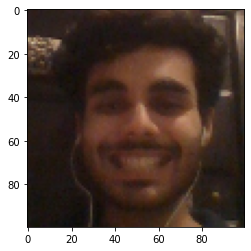

In [25]:
 plt.imshow(res[1])

In [13]:
# creating a data pipeline (MCSHBAP) , which includes :
# mapping -> cache -> shuffling -> batching -> prefetch


data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)
data = data.batch(16)
data = data.prefetch(8)

In [14]:
# getting 70% of training data
train_data = data.take(round(len(data)*0.7))

In [15]:
# 30% of testing datd
test_data = data.skip(round(len(data)*0.7)).take(round(len(data)*0.3))

In [29]:
len(train_data)

27

In [30]:
inp = Input(shape = (100 , 100 ,3) , name ='Input_image')

In [31]:
c1 = Conv2D(64 , (10 , 10) , activation= 'relu')(inp)

In [32]:
m1 = MaxPooling2D(64 ,  (2,2) , padding='same')(c1)

In [33]:
c2 = Conv2D(128 , (7 , 7) , activation= 'relu')(m1)

m2 = MaxPooling2D(64 ,  (2,2) , padding='same')(c2)
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [34]:
c3 = Conv2D(128 , (4 , 4) , activation= 'relu')(m2)
m3 = MaxPooling2D(64 ,  (2,2) , padding='same')(c3)


In [35]:
c4 = Conv2D(256 , (4,4) ,activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096 , activation='sigmoid')(f1)
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [16]:
def make_embedding():
    inp = Input(shape = (100 , 100 ,3) , name ='Input_image')
    
    #first block of NN
    c1 = Conv2D(64 , (10 , 10) , activation= 'relu')(inp)
    m1 = MaxPooling2D(64 ,  (2,2) , padding='same')(c1)
    
    #second block of NN
    c2 = Conv2D(128 , (7 , 7) , activation= 'relu')(m1)
    m2 = MaxPooling2D(64 ,  (2,2) , padding='same')(c2)
    
    #third block of NN
    c3 = Conv2D(128 , (4 , 4) , activation= 'relu')(m2)
    m3 = MaxPooling2D(64 ,  (2,2) , padding='same')(c3)
    
    #fourth block of NN
    c4 = Conv2D(256 , (4,4) ,activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096 , activation='sigmoid')(f1)
    
    return Model(inputs= [inp] , outputs = [d1] , name= 'embedding')

In [37]:
mod = make_embedding()

In [38]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [17]:
class L1Dist(Layer):
    
    #inherting the classes
    
    def __init__(self , **kwargs):
        super().__init__()
    
    
    #this will take the embedded images and convert it to absolute function after subtracting to get the distance
    def call(self , input_embedding , validation_embedding ):
        return tf.math.abs(input_embedding - validation_embedding)

In [40]:
l1 = L1Dist()

In [41]:
input_image = Input(name = 'Input_image' , shape = (105 , 105 , 3) )
valid_image = Input(name = 'Validation_image' , shape = (105, 105,3))
    

In [42]:
layer = L1Dist()
layer_name = 'distance'
distance = layer(mod(input_image ), mod(valid_image))

classifier = (Dense(1  ,activation='sigmoid')(distance))
distance

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [18]:
def make_siamese_model():
    
    #passing thru our two flowing pics (rivers)
    input_image = Input(name = 'Input_image' , shape = (100 , 100 , 3) )
    valid_image = Input(name = 'Validation_image' , shape = (100, 100,3))
    
    #this will make a distance layer and passing thru both images to embedding model for embedding those images and then to layer to make a distance of abs
    layer = L1Dist()
    layer._name = 'distance'
    distance = layer(mod(input_image ), mod(valid_image))
    
    #the last layer of output(classifier) whether it is 1 or 0
    classifier = Dense(1 , activation='sigmoid')(distance)
    
    #returning model 
    return Model(inputs= [input_image , valid_image] , outputs = classifier  , name = 'Siamese_Model_Network')

In [44]:
# def make_siamese_model(): 
    
#     # Anchor image input in the network
#     input_image = Input(name='input_img', shape=(100,100,3))
    
#     # Validation image in the network 
#     validation_image = Input(name='validation_img', shape=(100,100,3))
    
#     # Combine siamese distance components
#     siamese_layer = L1Dist()
#     siamese_layer._name = 'distance'
#     distances = siamese_layer(mod(input_image), mod(validation_image))
    
#     # Classification layer 
#     classifier = Dense(1, activation='sigmoid')(distances)
    
#     return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [29]:
siamese_model = make_siamese_model()

NameError: name 'mod' is not defined

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [47]:
opt = tf.keras.optimizers.Adam(1e-4)

In [48]:
checkpoint_dir = '.\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir , 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

In [49]:
@tf.function

def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        y_pred = siamese_model(X , training = True)
        
        loss = binary_cross_loss(y , y_pred)
    print(loss)
        
    grad = tape.gradient(loss , siamese_model.trainable_variables)
        
    opt.apply_gradients(zip(grad , siamese_model.trainable_variables))
    
    return loss

In [50]:
for idx , batch in enumerate(train_data):
    print(batch)

(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.14264706, 0.11519608, 0.08970588],
         [0.13946079, 0.10220588, 0.10906862],
         [0.16666667, 0.12058824, 0.1382353 ],
         ...,
         [0.4615196 , 0.37843138, 0.33700982],
         [0.375     , 0.3259804 , 0.2740196 ],
         [0.35367647, 0.32328433, 0.28112745]],

        [[0.13333334, 0.11470588, 0.0882353 ],
         [0.15490197, 0.11764706, 0.1245098 ],
         [0.15465686, 0.10857843, 0.1242647 ],
         ...,
         [0.5176471 , 0.44705883, 0.38578433],
         [0.39240196, 0.33848038, 0.2757353 ],
         [0.38504902, 0.34901962, 0.2901961 ]],

        [[0.14338236, 0.12401961, 0.0997549 ],
         [0.15      , 0.12401961, 0.11691176],
         [0.15882353, 0.11862745, 0.12401961],
         ...,
         [0.46715686, 0.40367648, 0.34387255],
         [0.4154412 , 0.35490197, 0.2995098 ],
         [0.40882352, 0.34779412, 0.30465686]],

        ...,

        [[0.35441175, 0.23382352

(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.13284314, 0.11887255, 0.08357843],
         [0.14411765, 0.10833333, 0.09093137],
         [0.15661764, 0.11053921, 0.10857843],
         ...,
         [0.47083333, 0.43259802, 0.3973039 ],
         [0.29436275, 0.26911765, 0.22916667],
         [0.24558823, 0.21495098, 0.2009804 ]],

        [[0.14117648, 0.11078431, 0.09117647],
         [0.15588236, 0.11470588, 0.11004902],
         [0.15539216, 0.10980392, 0.11102941],
         ...,
         [0.41593137, 0.3747549 , 0.3497549 ],
         [0.32230392, 0.29142156, 0.26127452],
         [0.25343138, 0.2129902 , 0.20637254]],

        [[0.16078432, 0.11568628, 0.11372549],
         [0.15955882, 0.11544117, 0.11593137],
         [0.15      , 0.11078431, 0.11470588],
         ...,
         [0.37892157, 0.33995098, 0.30465686],
         [0.3629902 , 0.3247549 , 0.28651962],
         [0.27794117, 0.22573529, 0.21691176]],

        ...,

        [[0.06127451, 0.07181372

(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.14754902, 0.1122549 , 0.09068628],
         [0.14166667, 0.10147059, 0.10833333],
         [0.15833333, 0.12107843, 0.13431373],
         ...,
         [0.33112746, 0.26740196, 0.23504902],
         [0.35759804, 0.30563724, 0.27328432],
         [0.35686275, 0.30588236, 0.27450982]],

        [[0.13799019, 0.10147059, 0.09044117],
         [0.15318628, 0.11642157, 0.11372549],
         [0.14705883, 0.1125    , 0.11421569],
         ...,
         [0.36593136, 0.3112745 , 0.27450982],
         [0.38504902, 0.33333334, 0.3009804 ],
         [0.38039216, 0.33235294, 0.3       ]],

        [[0.15612745, 0.1247549 , 0.11593137],
         [0.15343137, 0.12181372, 0.11470588],
         [0.15122549, 0.11544117, 0.10686275],
         ...,
         [0.44289216, 0.3897059 , 0.34632352],
         [0.3872549 , 0.34362745, 0.30465686],
         [0.3852941 , 0.34607843, 0.3107843 ]],

        ...,

        [[0.09044117, 0.08259804

(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.15465686, 0.1115196 , 0.1002451 ],
         [0.14068627, 0.10245098, 0.10833333],
         [0.15906863, 0.12377451, 0.1375    ],
         ...,
         [0.297549  , 0.22107843, 0.19607843],
         [0.3720588 , 0.3004902 , 0.28627452],
         [0.29436275, 0.2504902 , 0.2247549 ]],

        [[0.14779411, 0.10465686, 0.09534314],
         [0.15294118, 0.11421569, 0.12230392],
         [0.15563725, 0.11323529, 0.13014705],
         ...,
         [0.29828432, 0.22769608, 0.18259804],
         [0.33382353, 0.2723039 , 0.24313726],
         [0.33700982, 0.2977941 , 0.25857842]],

        [[0.1627451 , 0.11593137, 0.11544117],
         [0.16176471, 0.12156863, 0.13039216],
         [0.15539216, 0.10931373, 0.12696078],
         ...,
         [0.29509804, 0.23235294, 0.20269608],
         [0.29509804, 0.23431373, 0.21102941],
         [0.3970588 , 0.35563725, 0.32671568]],

        ...,

        [[0.06985294, 0.07769608

(<tf.Tensor: shape=(16, 100, 100, 3), dtype=float32, numpy=
array([[[[0.16176471, 0.11078431, 0.08676471],
         [0.15392157, 0.10098039, 0.10490196],
         [0.16176471, 0.11666667, 0.13529412],
         ...,
         [0.38946077, 0.34068626, 0.2840686 ],
         [0.38602942, 0.31740198, 0.26740196],
         [0.40392157, 0.3372549 , 0.30588236]],

        [[0.15588236, 0.10294118, 0.10490196],
         [0.16029412, 0.11102941, 0.13186274],
         [0.16078432, 0.11004902, 0.12941177],
         ...,
         [0.42843136, 0.38039216, 0.32205883],
         [0.40735295, 0.33872548, 0.2887255 ],
         [0.42181373, 0.34632352, 0.31887254]],

        [[0.15882353, 0.11764706, 0.12254902],
         [0.16470589, 0.11470588, 0.12745099],
         [0.17279412, 0.11176471, 0.12107843],
         ...,
         [0.4272059 , 0.37254903, 0.30784315],
         [0.42058823, 0.34558824, 0.29215688],
         [0.42034313, 0.34191176, 0.30710784]],

        ...,

        [[0.08529412, 0.08529412

In [33]:
def train(data , EPOCHS):
    for epoch in range(1 ,EPOCHS +1):
        print('\n EPOCHS {}/{}'.format(epoch , EPOCHS))
        prog = tf.keras.utils.Progbar(len(data))
    
        
        for idx , batch in enumerate(data):
            train_step(batch)
            prog.update(idx+1)
        


In [34]:
EPOCHS = 20

In [59]:
train(train_data , EPOCHS)


 EPOCHS 1/20
27/27 [==============================] - 1045s 38s/step

 EPOCHS 2/20
27/27 [==============================] - 797s 29s/step

 EPOCHS 3/20
27/27 [==============================] - 692s 26s/step

 EPOCHS 4/20
27/27 [==============================] - 693s 26s/step

 EPOCHS 5/20
27/27 [==============================] - 691s 26s/step

 EPOCHS 6/20
27/27 [==============================] - 690s 26s/step

 EPOCHS 7/20
27/27 [==============================] - 694s 26s/step

 EPOCHS 8/20
27/27 [==============================] - 689s 26s/step

 EPOCHS 9/20
27/27 [==============================] - 693s 26s/step

 EPOCHS 10/20
27/27 [==============================] - 688s 25s/step

 EPOCHS 11/20
27/27 [==============================] - 691s 26s/step

 EPOCHS 12/20
27/27 [==============================] - 690s 26s/step

 EPOCHS 13/20
27/27 [==============================] - 691s 26s/step

 EPOCHS 14/20
27/27 [==============================] - 690s 26s/step

 EPOCHS 15/20
27/27 [======

In [20]:
from tensorflow.keras.metrics import Recall , Precision , Accuracy

In [37]:
test_inputted_img , test_validation_img , y_true = test_data.as_numpy_iterator().next()

In [21]:
y_pred = siamese_model.predict([test_inputted_img , test_validation_img])

NameError: name 'siamese_model' is not defined

In [64]:
y_pred

array([[9.9999982e-01],
       [9.9988681e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.6234820e-08],
       [1.0000000e+00],
       [9.9999976e-01],
       [1.6315866e-05],
       [4.0868237e-08],
       [6.6079345e-08],
       [9.9999917e-01],
       [1.4021855e-07],
       [4.2450351e-06],
       [1.0000000e+00],
       [6.8241327e-08],
       [3.3622120e-05]], dtype=float32)

In [68]:
[1 if prediction > 0.5 else 0 for prediction in y_true]

[1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]

In [69]:
pre = Precision()
pre.update_state(y_pred , y_true)
pre.result().numpy()

1.0

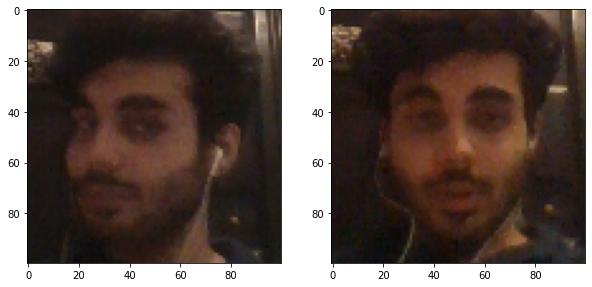

In [73]:
plt.figure(figsize = (10 ,10))
plt.subplot(1 , 2, 1)
plt.imshow(test_inputted_img[0])

plt.subplot(1 , 2 , 2)
plt.imshow(test_validation_img[0])



In [74]:
siamese_model.save('siamese_model.h5')

In [20]:
preds = model.predict([test_inputted_img , test_validation_img])

In [35]:
model = tf.keras.models.load_model('siamese_model.h5' , custom_objects={'L1Dist':L1Dist})

In [38]:
y_pred = model.predict([test_inputted_img , test_validation_img])

In [39]:
[1 if predicition > 0.5 else 0 for predicition in y_pred]

[1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]

In [41]:
from tensorflow.keras.metrics import Recall , Accuracy , Precision

In [44]:
re = Accuracy()

re.update_state(y_true , y_pred)
re.result().numpy()

0.25

In [21]:
[1 if predictions > 0.5 else 0 for predictions in preds]

[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1]

In [25]:
from tensorflow.keras.metrics import Accuracy

In [26]:
acc = Accuracy()

In [27]:
acc.update_state(y_true , y_pred)

NameError: name 'y_pred' is not defined

In [28]:
acc.result().numpy()

0.0

In [24]:
def verify  (model , detection_threshold , verification_threshold ):
    results  = []
    
    for image in os.listdir(os.path.join('application_data' , 'verification')):
        verification_image = preprocess(os.path.join('application_data' , 'verification' , image))
        input_image = preprocess(os.path.join('application_data' , 'input_images' , 'inputimg.jpg'))
        
        result = model.predict(list(np.expand_dims([input_image , verification_image] , axis = 1)))
        results.append(result)
    
    detection = np.sum(np.array(results )> detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data' , 'verification' )))
    verified = verification > verification_threshold
    
    return results , verified

In [27]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret , frame = cap.read()
    
    frame = frame[220 : 220+250 , 220: 220+250 , : ]
    cv2.imshow('VERIFICATION_IMAGE' , frame)
    
    if cv2.waitKey(1) & 0XFF == ord('v'):
        cv2.imwrite(os.path.join('application_data' , 'input_images' , 'inputimg.jpg') , frame)
        
        results , ver = verify(model , 0.5 , 0.5)
        print(ver)
        
        
    if cv2.waitKey(1) & 0XFF == ord('q'):qqqqqqqqqq
        break

cap.release()
cv2.destroyAllWindows()

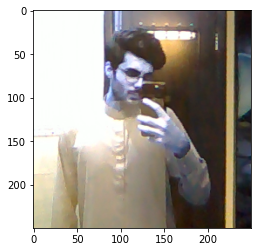

In [28]:
plt.imshow(frame)

In [29]:
results

[array([[0.86305976]], dtype=float32),
 array([[0.7279841]], dtype=float32),
 array([[0.01279968]], dtype=float32),
 array([[0.01787707]], dtype=float32),
 array([[0.23426479]], dtype=float32),
 array([[0.97982264]], dtype=float32),
 array([[0.33512148]], dtype=float32),
 array([[0.9989884]], dtype=float32),
 array([[0.99848187]], dtype=float32),
 array([[0.5561679]], dtype=float32),
 array([[0.6905609]], dtype=float32),
 array([[0.6613843]], dtype=float32),
 array([[0.9916401]], dtype=float32),
 array([[0.9929025]], dtype=float32),
 array([[0.9572904]], dtype=float32),
 array([[0.99514925]], dtype=float32),
 array([[0.24308729]], dtype=float32),
 array([[0.9563211]], dtype=float32),
 array([[0.99346554]], dtype=float32),
 array([[0.99033266]], dtype=float32),
 array([[0.8976319]], dtype=float32),
 array([[0.99814165]], dtype=float32),
 array([[0.9954137]], dtype=float32),
 array([[0.9984518]], dtype=float32),
 array([[0.95686173]], dtype=float32),
 array([[0.9983623]], dtype=float32),

In [32]:
np.squeeze(results)

37